In [3]:
%load_ext jupyter_black

BoundingBox(south=20, north=40, west=-120, east=-60, shape=(700, 250), dtype=<class 'numpy.float32'>)

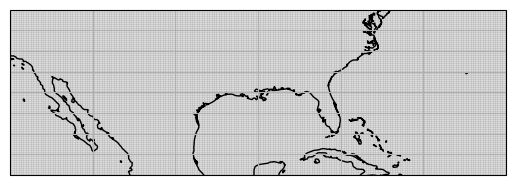

In [38]:
from dataclasses import dataclass, field
from functools import lru_cache, wraps
from typing import Callable, Literal

import numpy as np
from numpy.typing import NDArray
import nvector as nv
import matplotlib.pyplot as plt
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.crs as ccrs


@dataclass
class BoundingBox:
    """
    Nominatim API
    Nominatim API returns a boundingbox property of the form:

    south Latitude, north Latitude, west Longitude, east Longitude
    For example, Greater London in JSON format:

    "boundingbox":["51.2867602","51.6918741","-0.5103751","0.3340155"]


    ```
    bbox = BoundingBox(20.005, 54.995, -129.995, -60.005, shape=(7000, 2500))
    with gpu_session(files) as gdf:
    gdf["X"] = bbox.fit_array(gdf["X"].values, axis=0)
    gdf["Y"] = bbox.fit_array(gdf["Y"].values, axis=1)
    ```
    """

    south: float
    north: float
    west: float
    east: float
    shape: tuple[int, int]
    frame_e: nv.FrameE = field(repr=False, default=nv.FrameE(name="WGS84"))
    projection: ccrs.Projection = field(repr=False, default=ccrs.PlateCarree())
    dtype: np.dtype = np.float32

    @property
    def lat(self) -> NDArray:
        _, num = self.shape
        return np.linspace(self.south, self.north, num, dtype=self.dtype)

    @property
    def lon(self) -> NDArray:
        num, _ = self.shape
        return np.linspace(self.west, self.east, num, dtype=self.dtype)

    def __post_init__(self):
        self.__matrix = np.array(np.meshgrid(self.lon, self.lat))

    @property
    def matrix(self) -> NDArray:
        return self.__matrix

    @property
    def extent(self):
        return np.array([self.west, self.east, self.south, self.north], dtype=self.dtype)

    def get_axes(self) -> GeoAxes:
        return plt.axes(projection=self.projection)

    def meshgrid(self, indexing: Literal["xy", "ij"] = "xy") -> tuple[NDArray, NDArray]:
        return np.meshgrid(self.lon, self.lat, indexing=indexing)

    def set_axes(self, resolution: str = "auto", color: str = "black", **kwargs: any):
        ax = self.get_axes()
        ax.set_extent(self.extent, crs=self.projection)
        ax.coastlines(resolution=resolution)
        ax.gridlines()
        ax.plot(
            *self.meshgrid("ij"),
            linewidth=0.5,
            color="black",
            alpha=0.1,
        )
        ax.plot(
            *self.meshgrid("xy"),
            color="black",
            linewidth=0.5,
            alpha=0.1,
        )
        return self


south, north, west, east = 20, 40, -120, -60
shape = np.array((70, 25)) * 10
bbox = BoundingBox(south, north, west, east, shape=tuple(shape))
bbox.set_axes()
# bbox.matrix.T

In [47]:
def np_cache(function):
    @lru_cache()
    def cached_wrapper(lat, lon):
        array = np.array(np.meshgrid(lat, lon))
        return function(array)

    @wraps(function)
    def wrapper(a1, a2):
        return cached_wrapper(tuple(a1), tuple(a2))

    # copy lru_cache attributes over too
    wrapper.cache_info = cached_wrapper.cache_info
    wrapper.cache_clear = cached_wrapper.cache_clear

    return wrapper


@np_cache
def f(a):
    print("hello")
    return a


f(np.array([1, 2]), np.array([1, 2])), f(np.array([1, 2]), np.array([1, 2]))

hello


(array([[[1, 2],
         [1, 2]],
 
        [[1, 1],
         [2, 2]]]),
 array([[[1, 2],
         [1, 2]],
 
        [[1, 1],
         [2, 2]]]))